In [1]:
import sys
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

from functools import partial

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('../..')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"]      = 11

In [5]:
filename = '/Users/romoluque_c/LEGEND/BACON/datatest/run-11_20_2023-file_1.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

In [31]:
RawTree.items()

[('eventData', <TBranchElement 'eventData' (9 subbranches) at 0x00014af40550>),
 ('eventData/TNamed',
  <TBranchElement 'TNamed' (3 subbranches) at 0x00014af419f0>),
 ('eventData/TNamed/TObject',
  <TBranchElement 'TObject' (2 subbranches) at 0x00014af41f30>),
 ('eventData/TNamed/TObject/fUniqueID',
  <TBranchElement 'fUniqueID' at 0x00014af42470>),
 ('eventData/TNamed/TObject/fBits',
  <TBranchElement 'fBits' at 0x00014af42e00>),
 ('eventData/TNamed/fName', <TBranchElement 'fName' at 0x00014af43940>),
 ('eventData/TNamed/fTitle', <TBranchElement 'fTitle' at 0x00014af6c2e0>),
 ('eventData/evtime', <TBranchElement 'evtime' at 0x00014af6ce20>),
 ('eventData/sec', <TBranchElement 'sec' at 0x00014af6d780>),
 ('eventData/min', <TBranchElement 'min' at 0x00014af6e0e0>),
 ('eventData/hour', <TBranchElement 'hour' at 0x00014af6ea40>),
 ('eventData/day', <TBranchElement 'day' at 0x00014af6f3a0>),
 ('eventData/mon', <TBranchElement 'mon' at 0x00014af6fd00>),
 ('eventData/year', <TBranchElement '

## Example of one event for the 12 SiPMs:

#### Trigger channels: 9, 10, 11 (the wfs are inverted)
#### "Normal" channels : 0 - 8

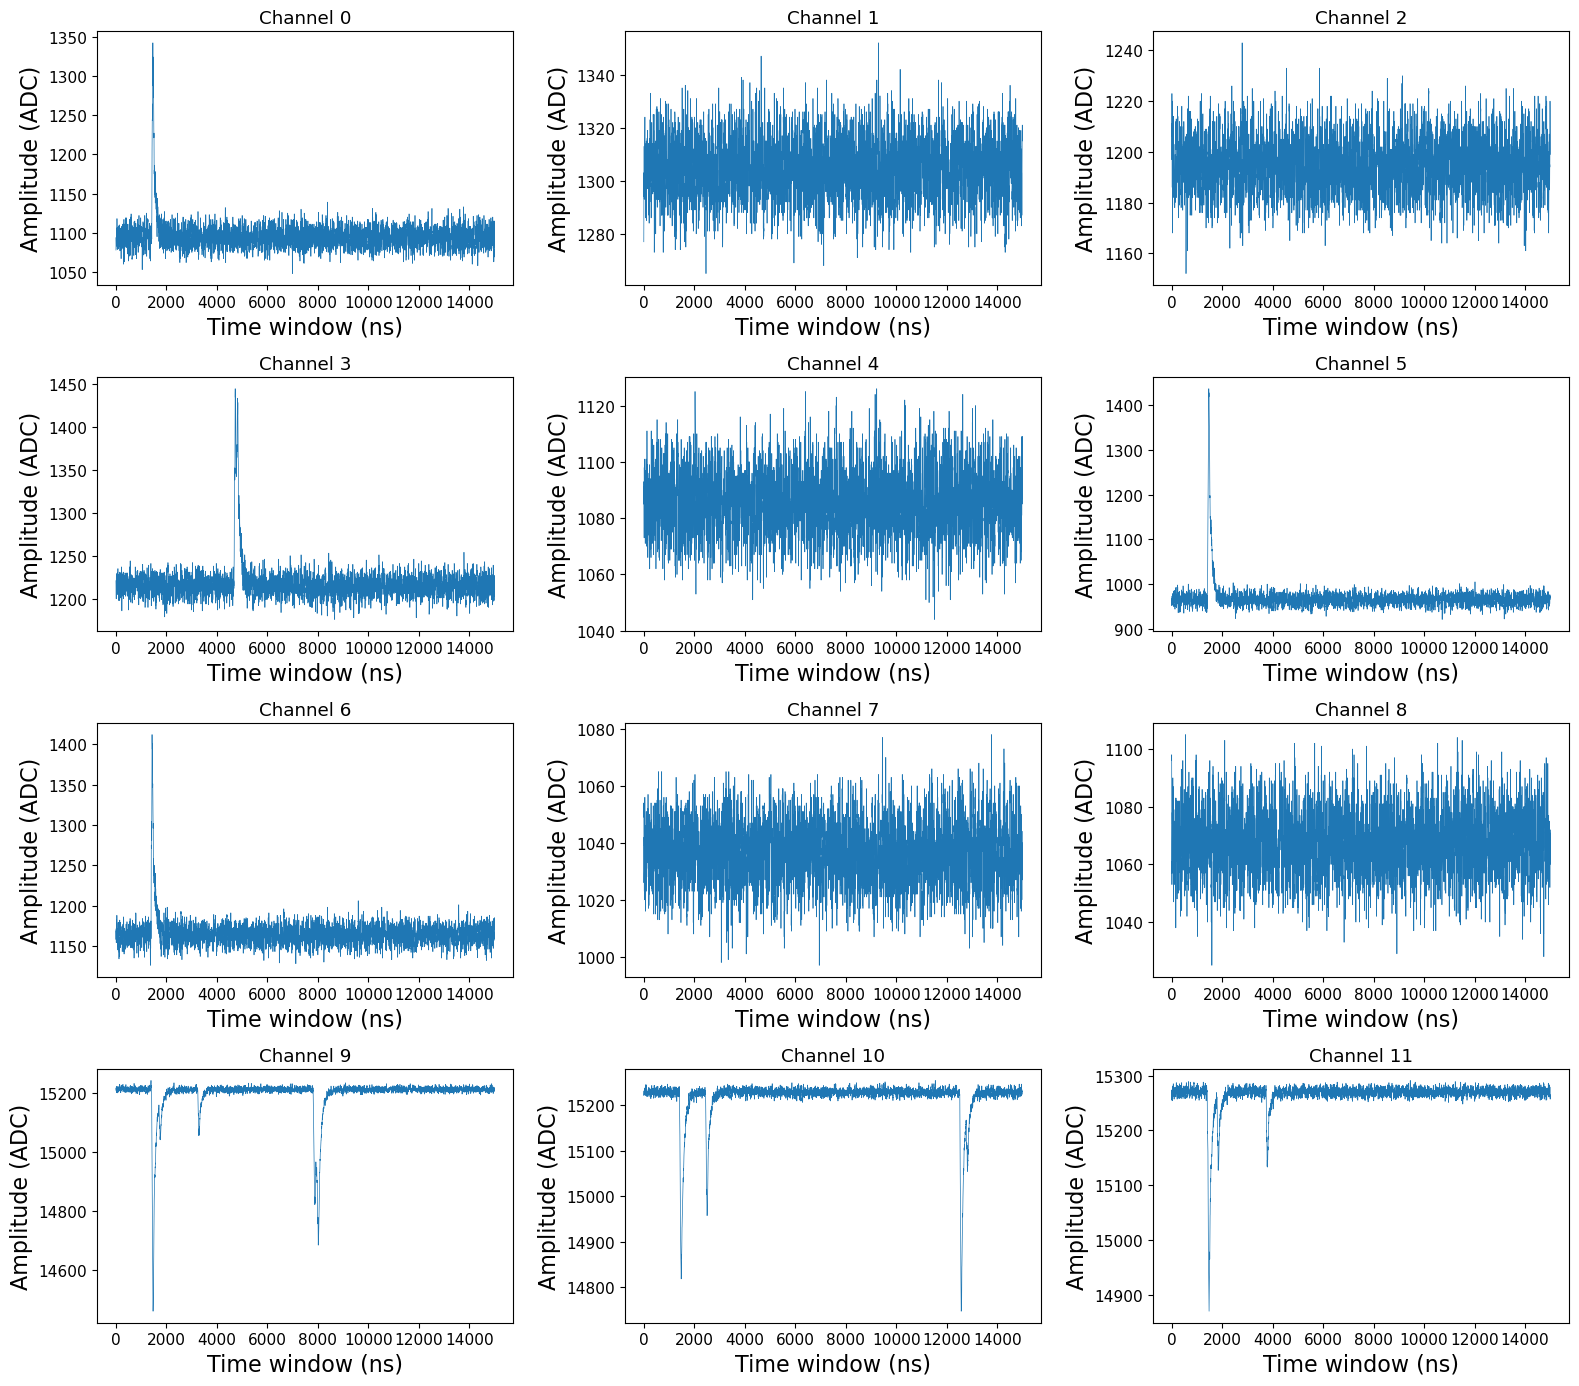

In [6]:
choose_evt  = 4
total_SiPMs = 12
fig, axs    = plt.subplots(4, 3, figsize=(16, 14))
for ch in range(total_SiPMs):
    i = int(ch/3)
    j = ch%3
    wf = np.array(RawTree[f'chan{ch}/rdigi'].array())[choose_evt]
    axs[i][j].plot(2*np.arange(len(wf)), wf, linewidth=0.5)
    axs[i][j].set_xlabel('Time window (ns)', fontsize=16)
    axs[i][j].set_ylabel('Amplitude (ADC)', fontsize=16)
    axs[i][j].set_title(f"Channel {ch}")
plt.tight_layout()
plt.show()

### Baseline should be subtracted

In [38]:
normal_chs = range(9)

## Get all the wfs for the normal channels:
wfs_dict = {ch: pf.wfs_from_rawtree(RawTree, ch)
            for ch in normal_chs}

In [37]:
len(wfs_dict[0][0])*2

15000

In [7]:
## Subtract baseline
max_smpl_bsl  = 650 # Max sample of the waveform to compute the baseline
subt_wfs_dict = {ch: np.array([pf.subtract_baseline(fwf,
                                                    mode=True,
                                                    wf_range_bsl=(0, max_smpl_bsl))
                                                    for fwf in wfs_dict[ch]])
                 if len(wfs_dict[ch])!=0 else []
                 for ch in normal_chs}

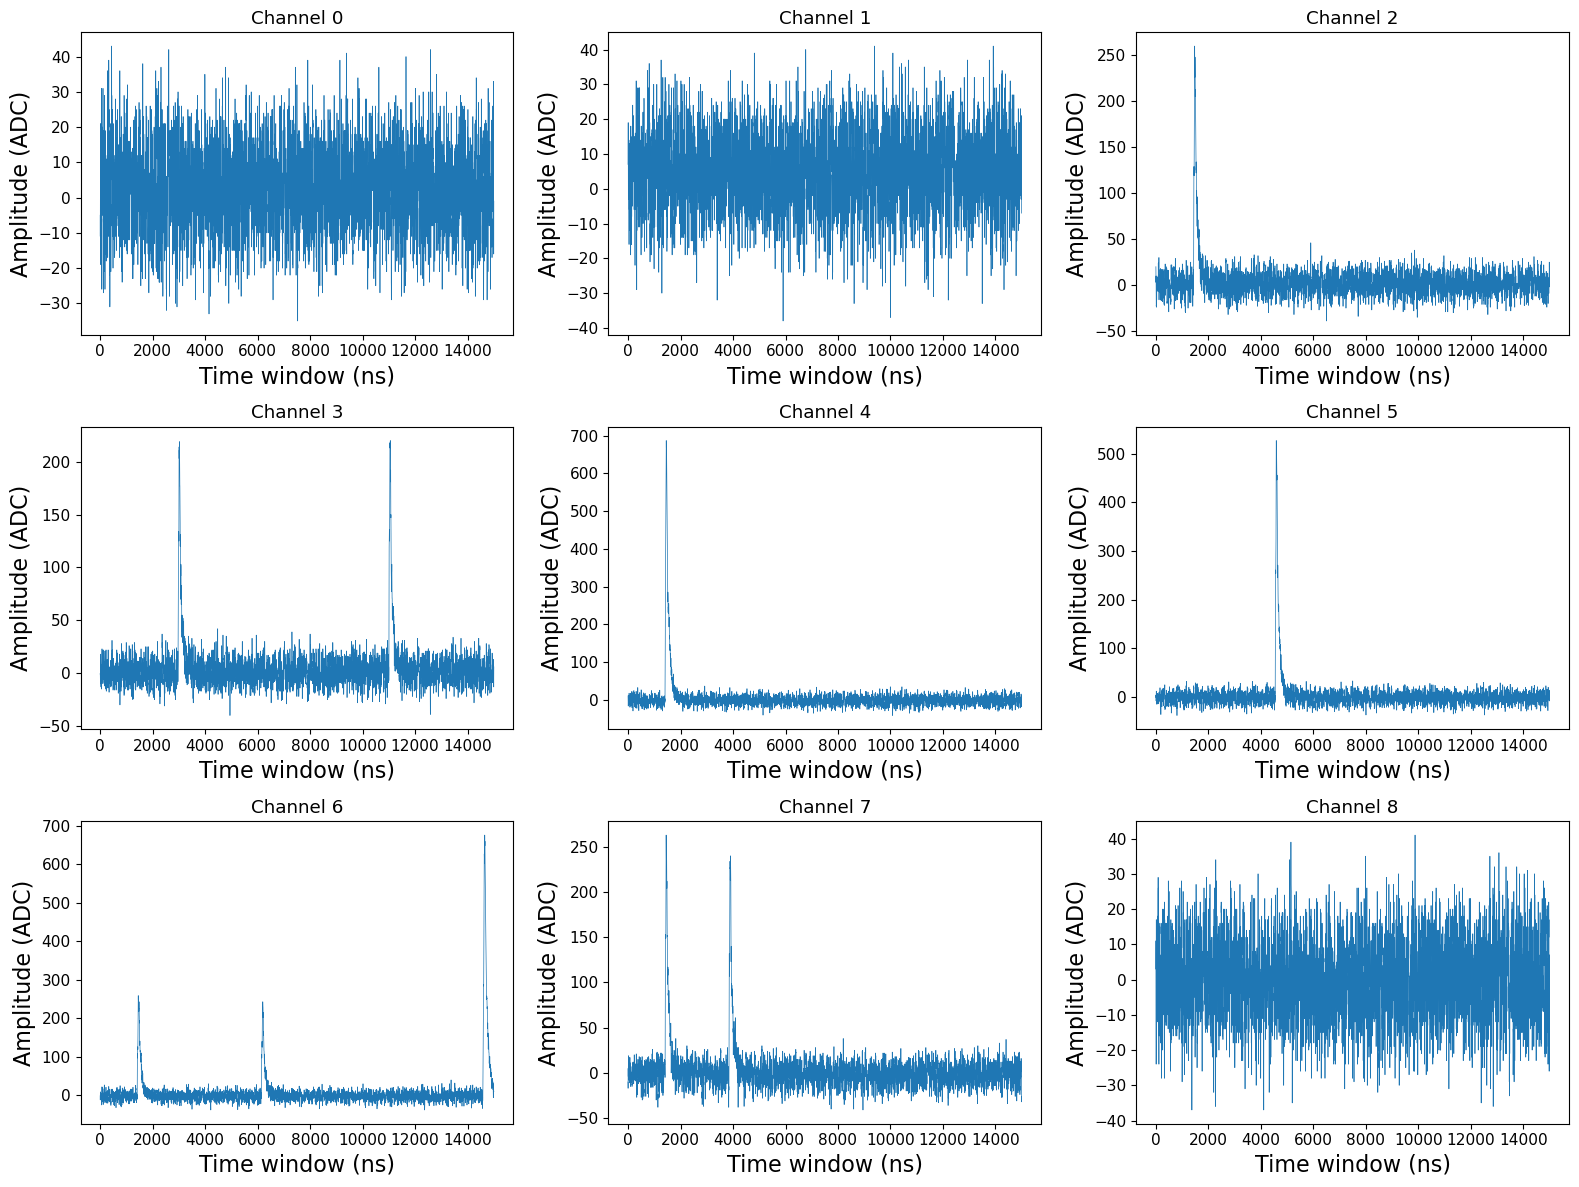

In [43]:
choose_evt  = 5
fig, axs    = plt.subplots(3, 3, figsize=(16, 12))
for ch in normal_chs:
    i = int(ch/3)
    j = ch%3
    wf = subt_wfs_dict[ch][choose_evt]
    axs[i][j].plot(2*np.arange(len(wf)), wf, linewidth=0.5)
    axs[i][j].set_xlabel('Time window (ns)', fontsize=16)
    axs[i][j].set_ylabel('Amplitude (ADC)', fontsize=16)
    axs[i][j].set_title(f"Channel {ch}")
plt.tight_layout()
plt.show()

### Summed waveforms for each channel (for this particular file)

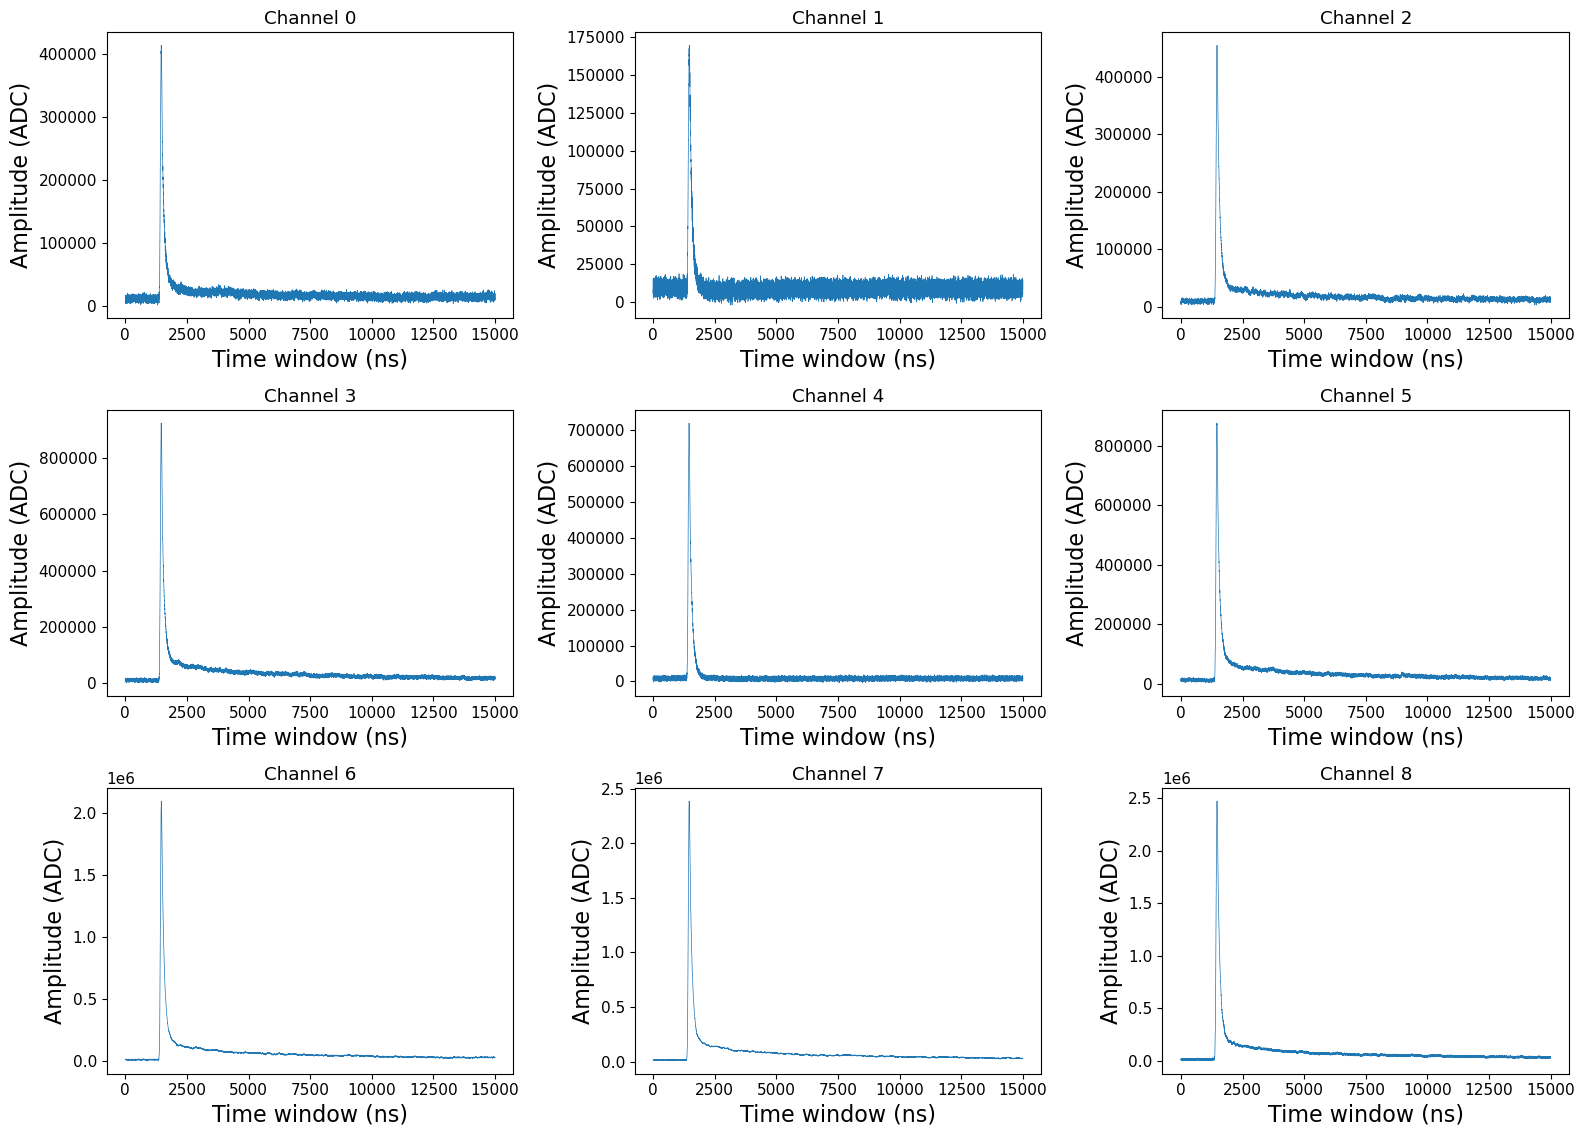

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(16, 11.5))
for ch in normal_chs:
    i = int(ch/3)
    j = ch%3
    sum_wf = np.sum(subt_wfs_dict[ch], axis=0)
    axs[i][j].plot(2*np.arange(len(sum_wf)), sum_wf, linewidth=0.5)
    axs[i][j].set_xlabel('Time window (ns)', fontsize=16)
    axs[i][j].set_ylabel('Amplitude (ADC)', fontsize=16)
    axs[i][j].set_title(f"Channel {ch}")
plt.tight_layout()
plt.show()

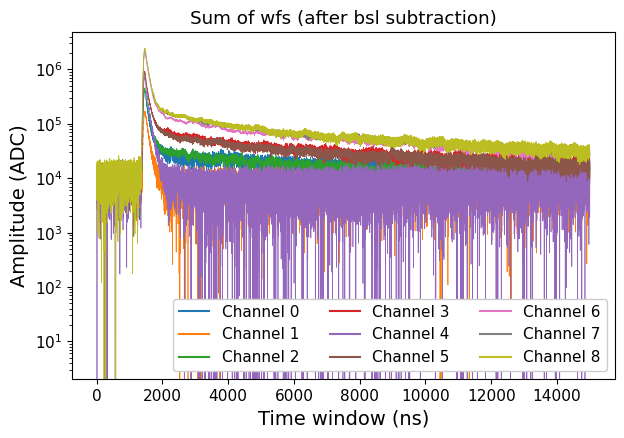

In [9]:
plt.figure(figsize=(7, 4.5))
for ch in normal_chs:
    sum_wf = np.sum(subt_wfs_dict[ch], axis=0)
    plt.plot(2*np.arange(len(sum_wf)), sum_wf, linewidth=0.5, label=f'Channel {ch}')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.title(f"Sum of wfs (after bsl subtraction)")
plt.yscale('log')

# Customize LEGEND
leg = plt.legend(ncol=3, loc=4)
leg.get_frame().set_alpha(1)
for line in leg.get_lines():
    line.set_linewidth(1.5)
plt.show()

### Looking at the different SiPM rows:

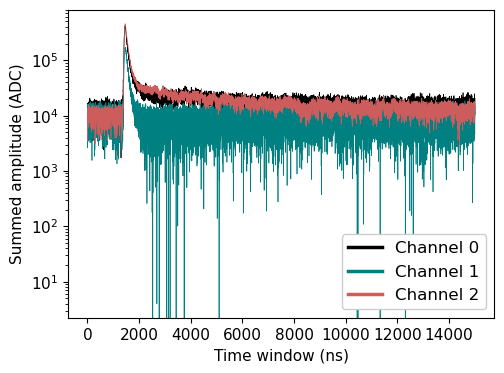

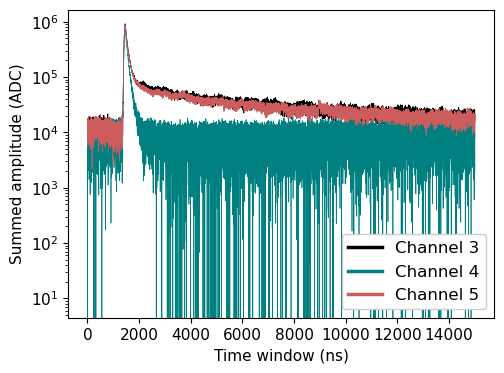

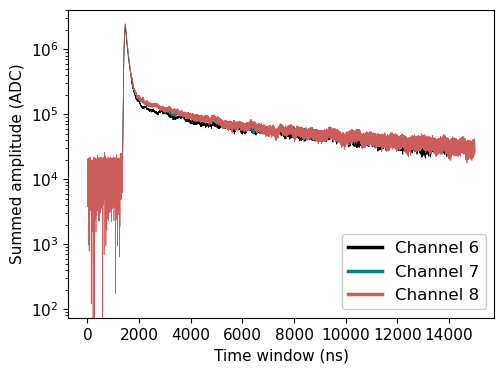

In [10]:
for ch_row in np.array(normal_chs).reshape(3,3):
    plt.figure(figsize=(5.5, 4))
    for ch, col in zip(ch_row, ['k', 'teal', 'indianred']):
        sum_wf = np.sum(subt_wfs_dict[ch], axis=0)
        plt.plot(2*np.arange(len(sum_wf)), sum_wf, linewidth=0.5, label=f'Channel {ch}', color=col)
    
    plt.xlabel('Time window (ns)'      )
    plt.ylabel('Summed amplitude (ADC)')
    plt.yscale('log')
    plt.legend()
    leg = plt.legend(ncol=1, fontsize=12, loc=4)
    leg.get_frame().set_alpha(1)
    for line in leg.get_lines():
        line.set_linewidth(2.5)
    plt.show()

## Looking at the peaks for one channel

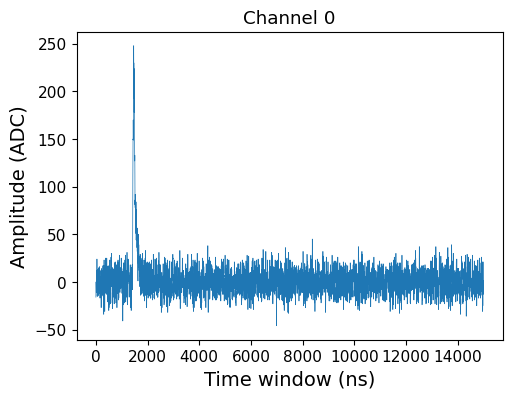

In [24]:
choose_evt = 4
sel_ch     = 0
plt.figure(figsize=(5.5, 4))
wf = subt_wfs_dict[sel_ch][choose_evt]
plt.plot(2*np.arange(len(wf)), wf, linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.title(f"Channel {sel_ch}")
plt.show()

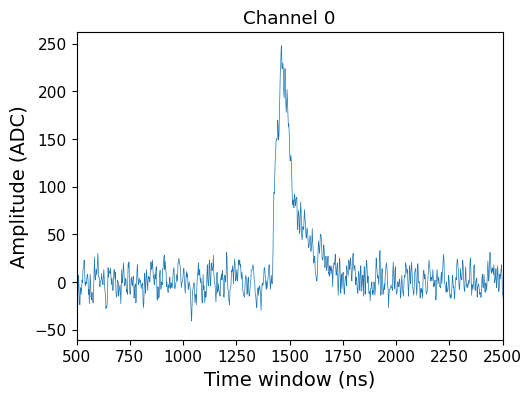

In [25]:
choose_evt = 4
sel_ch     = 0
plt.figure(figsize=(5.5, 4))
wf = subt_wfs_dict[sel_ch][choose_evt]
plt.plot(2*np.arange(len(wf)), wf, linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.title(f"Channel {sel_ch}")
plt.xlim(500, 2500)
plt.show()

## Filter the wf to reduce noise:

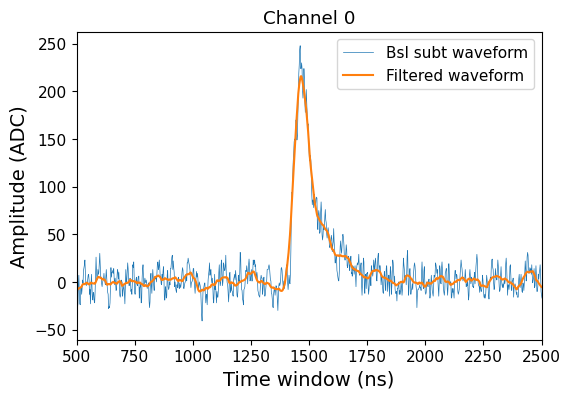

In [29]:
choose_evt = 4
sel_ch     = 0

sg_filter_window    = 50
sg_filter_polyorder = 3

plt.figure(figsize=(6, 4))
wf  = subt_wfs_dict[sel_ch][choose_evt]
fwf = savgol_filter(wf, window_length=sg_filter_window, polyorder=sg_filter_polyorder)
plt.plot(2*np.arange(len(wf)),  wf,  linewidth=0.5, label='Bsl subt waveform')
plt.plot(2*np.arange(len(fwf)), fwf, linewidth=1.5, label='Filtered waveform')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.title(f"Channel {sel_ch}")
plt.xlim(500, 2500)
plt.legend()
plt.show()